In [1]:
import librosa
import os
import glob
from typing import Tuple
import numpy as np
import pandas as pd
import scipy
import skimage
import matplotlib.pyplot as plt
from tqdm import tqdm 

audio_folder = "/home/xianbin/Documents/Projects/SoundDuck/data/dataset/audio"

In [2]:
audio_files = glob.glob(os.path.join(audio_folder, "**", "*.mp3"))

In [3]:
def load_audio(filepath:str, sample_rate=48000) -> Tuple[np.ndarray, int]:
    return librosa.load(filepath, sr=sample_rate, mono=True)

def create_mel_filterbank(sample_rate, frame_len, num_bands, min_freq,
                          max_freq, corner=700):
    """
    Creates a mel filterbank of `num_bands` triangular filters, with the first
    filter starting at `min_freq` and the last one stopping at `max_freq`.
    Returns the filterbank as a matrix suitable for a dot product against
    magnitude spectra created from samples at a sample rate of `sample_rate`
    with a window length of `frame_len` samples.
    """
    # prepare output matrix
    input_bins = (frame_len // 2) + 1
    filterbank = np.zeros((input_bins, num_bands))

    # mel-spaced peak frequencies
    coefficient = 1000/np.log1p(1000 / corner)
    min_mel = coefficient * np.log1p(min_freq / corner)
    max_mel = coefficient * np.log1p(max_freq / corner)
    spacing = (max_mel - min_mel) / (num_bands + 1)
    peaks_mel = min_mel + np.arange(num_bands + 2) * spacing
    peaks_hz = corner * (np.exp(peaks_mel / coefficient) - 1)
    fft_freqs = np.linspace(0, sample_rate / 2., input_bins)
    peaks_bin = np.searchsorted(fft_freqs, peaks_hz)

    # fill output matrix with triangular filters
    for b, filt in enumerate(filterbank.T):
        # The triangle starts at the previous filter's peak (peaks_freq[b]),
        # has its maximum at peaks_freq[b+1] and ends at peaks_freq[b+2].
        left_hz, _, right_hz = peaks_hz[b:b + 3]  # b, b+1, b+2
        left_bin, top_bin, right_bin = peaks_bin[b:b + 3]
        # Create triangular filter compatible to yaafe
        filt[left_bin:top_bin] = ((fft_freqs[left_bin:top_bin] - left_hz) /
                                  (top_bin - left_bin))
        filt[top_bin:right_bin] = ((right_hz - fft_freqs[top_bin:right_bin]) /
                                   (right_bin - top_bin))
        filt[left_bin:right_bin] /= filt[left_bin:right_bin].sum()

    return filterbank

def calculate_indicator(melspec, factor=3):
    # calculate signal regions
    row_median = np.median(melspec, axis=1).reshape(-1, 1)
    col_median = np.median(melspec, axis=0).reshape(1, -1)
    
    row_mask = melspec > (row_median*factor)
    col_mask = melspec > (col_median*factor)
    mask = row_mask*col_mask
    
    #perform erosion then dilation
    mask = skimage.morphology.binary_erosion(mask, footprint=np.ones((4,4)))
    mask = skimage.morphology.binary_dilation(mask, footprint=np.ones((4,4)))
    
    indicator = np.any(mask, axis=0)
    indicator = skimage.morphology.binary_dilation(indicator, footprint=np.ones((4,)))
    indicator = skimage.morphology.binary_dilation(indicator, footprint=np.ones((4,)))
    
    return indicator

def concatenate_parts(indicator, y):
    change = np.where(indicator[:-1] != indicator[1:])[0]

    if indicator[0]==True:
        left_edge = np.concatenate(([0], change[1::2]))
        right_edge = change[0::2]
    else:
        left_edge = change[::2]
        right_edge = change[1::2]
        
    if indicator[-1] == True:
        right_edge = np.append(right_edge, len(indicator))
        
    left_timings = left_edge*512*0.75 - 256
    left_timings = left_timings.astype(int)
    right_timings = right_edge*512*0.75 - 256
    right_timings = right_timings.astype(int)
    parts = [y[j:k+1] for (j,k) in zip(left_timings, right_timings)]
    if len(parts) > 0:
        output_y = np.concatenate(parts)
        return output_y

def split_audio(y, length=384, sr=48000):
    if len(y) < 512:
        return []
    x_hann = librosa.stft(y, window='hann', n_fft=512, win_length=512, hop_length=int(512*0.75))
    melfb = create_mel_filterbank(sample_rate=sr, frame_len=512, num_bands=64, min_freq=150, max_freq=15000, corner=1750).T
    melspec: np.ndarray = np.einsum("...ft,mf->...mt", np.abs(x_hann), melfb, optimize=True)
    
    output = []
    n_samples = melspec.shape[1]//length
    for i in range(n_samples):
        output.append(melspec[:, i*length:(i+1)*length])
    
    return output

def write_output(folder, filename, output):
    filepaths = []
    for i in range(len(output)):
        filepath = os.path.join(folder, f"{filename}_{i}.tif")
        skimage.io.imsave(filepath, output[i])
        filepaths.append(filepath)
        
    return filepaths


In [6]:
output_df = pd.DataFrame(columns = ["filepath", "animal", "is_signal"])
omit_count = 0
for i, file in enumerate(tqdm(audio_files)):
    folder, filename = os.path.split(file)
    filename = os.path.splitext(filename)[0]
    animal = os.path.split(folder)[-1]
    split_folder = os.path.realpath(os.path.join(folder, "..", "..", "audio_split"))
    os.makedirs(split_folder, exist_ok=True)
    signal_folder = os.path.join(split_folder, "signal")
    os.makedirs(signal_folder, exist_ok=True)
    noise_folder = os.path.join(split_folder, "noise")
    os.makedirs(noise_folder, exist_ok=True)
    
    y, sr = load_audio(file)
    x_hann = librosa.stft(y, window='hann', n_fft=512, win_length=512, hop_length=int(512*0.75))
    melfb = create_mel_filterbank(sample_rate=sr, frame_len=512, num_bands=64, min_freq=150, max_freq=15000, corner=1750).T
    melspec: np.ndarray = np.einsum("...ft,mf->...mt", np.abs(x_hann), melfb, optimize=True)
    
    signal_indicator = calculate_indicator(melspec, factor=3)

    noise_indicator = calculate_indicator(melspec, factor=2.5)
    noise_indicator = ~noise_indicator
    
    signal_y = concatenate_parts(signal_indicator, y)
    if signal_y is not None:
        signal_output = split_audio(signal_y, sr=sr)
        filepaths = write_output(signal_folder, filename, signal_output)
        output_df = pd.concat((output_df, pd.DataFrame.from_dict({"filepath": filepaths, "animal": [animal]*len(filepaths), "is_signal": [True]*len(filepaths)})))

    noise_y = concatenate_parts(noise_indicator, y)
    if noise_y is not None:
        noise_output = split_audio(noise_y, sr=sr)
        filepaths = write_output(noise_folder, filename, noise_output)
        output_df = pd.concat((output_df, pd.DataFrame.from_dict({"filepath": filepaths, "animal": [animal]*len(filepaths), "is_signal": [False]*len(filepaths)})))

output_df = output_df.reset_index(drop=True)

  0%|          | 0/1306 [00:00<?, ?it/s]


In [13]:
output_df.to_csv(os.path.join(split_folder, "data.csv"), index=False)

In [7]:
import soundfile as sf

sf.write('stereo_file.wav', signal_y, sr)

In [18]:
melspec.shape

(64, 5567)

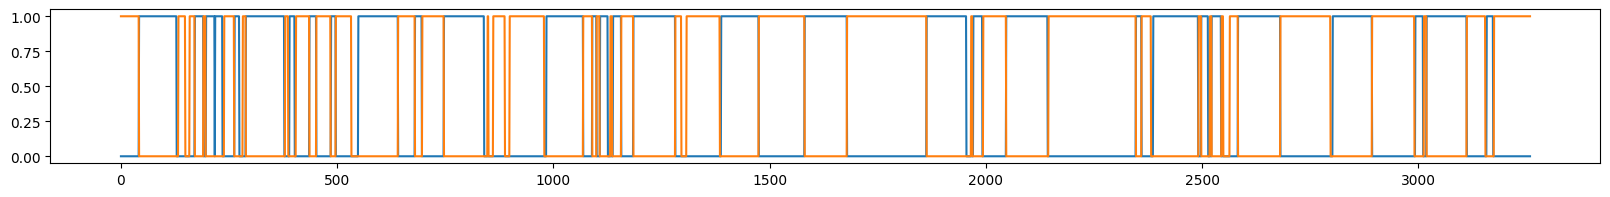

In [7]:
plt.figure(figsize=(20,2))
plt.plot(signal_indicator)
# plt.plot(left_edge, np.ones_like(left_edge), "x")
# plt.plot(right_edge, np.ones_like(right_edge), ".")
plt.plot(noise_indicator)

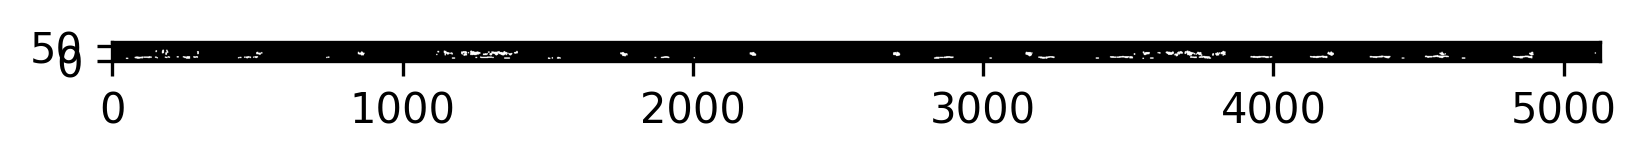

In [14]:
plt.figure(dpi=300)
plt.imshow(mask, cmap="Greys_r")
plt.gca().invert_yaxis()

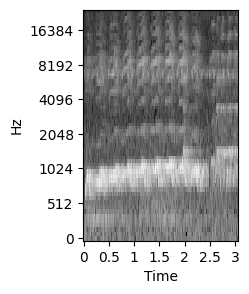

In [41]:
melspec = skimage.io.imread("/home/xianbin/Documents/Projects/SoundDuck/data/dataset/audio_split/signal/179229_0.tif")
plt.figure(figsize=(2, 3))
librosa.display.specshow(librosa.power_to_db(melspec, ref=np.max),
                         y_axis='mel', x_axis='time', sr=sr, hop_length=int(512*0.75), cmap='gray')

In [8]:
from IPython.display import Audio

In [12]:
Audio(data=signal_y, rate=sr)

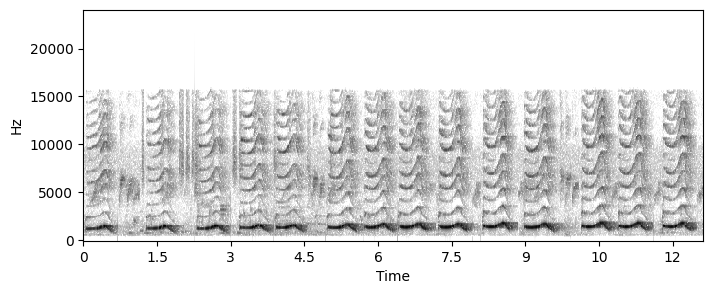

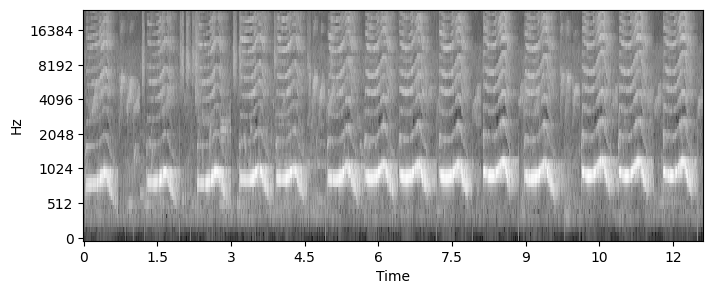

In [13]:
x_hann = librosa.stft(signal_y, window='hann', n_fft=512, win_length=512, hop_length=int(512*0.75))
melfb = create_mel_filterbank(sample_rate=sr, frame_len=512, num_bands=64, min_freq=150, max_freq=15000, corner=1750).T
melspec: np.ndarray = np.einsum("...ft,mf->...mt", np.abs(x_hann), melfb, optimize=True)

plt.figure(figsize=(8, 3))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(x_hann), ref=np.max), 
                         y_axis='linear', x_axis='time', sr=sr, hop_length=int(512*0.75), cmap='gray_r')

plt.figure(figsize=(8, 3))
librosa.display.specshow(librosa.power_to_db(melspec, ref=np.max),
                         y_axis='mel', x_axis='time', sr=sr, hop_length=int(512*0.75), cmap='gray')

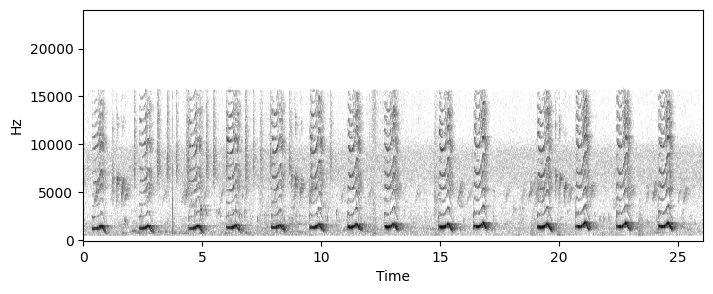

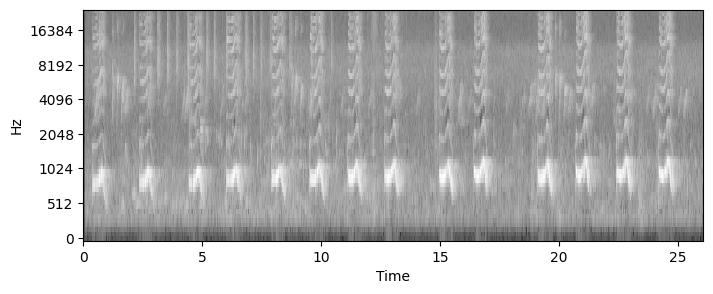

In [ ]:
x_hann = librosa.stft(y, window='hann', n_fft=512, win_length=512, hop_length=int(512*0.75))
melfb = create_mel_filterbank(sample_rate=sr, frame_len=512, num_bands=64, min_freq=150, max_freq=15000, corner=1750).T
melspec: np.ndarray = np.einsum("...ft,mf->...mt", np.abs(x_hann), melfb, optimize=True)

plt.figure(figsize=(8, 3))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(x_hann), ref=np.max), 
                         y_axis='linear', x_axis='time', sr=sr, hop_length=int(512*0.75), cmap='gray_r')

plt.figure(figsize=(8, 3))
librosa.display.specshow(librosa.power_to_db(melspec, ref=np.max),
                         y_axis='mel', x_axis='time', sr=sr, hop_length=int(512*0.75), cmap='gray')

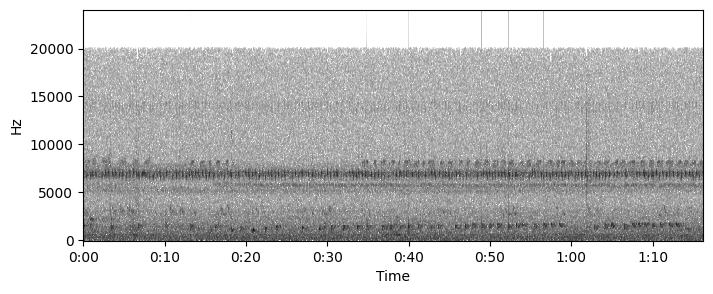

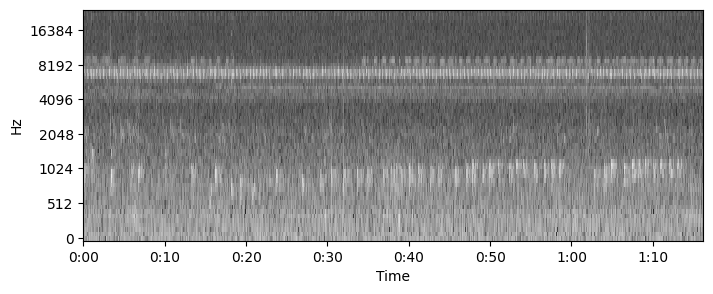

In [15]:
plt.figure(figsize=(8, 3))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(x_hann), ref=np.max), 
                         y_axis='linear', x_axis='time', sr=sr, hop_length=int(512*0.75), cmap='gray_r')

plt.figure(figsize=(8, 3))
librosa.display.specshow(librosa.power_to_db(melspec, ref=np.max),
                         y_axis='mel', x_axis='time', sr=sr, hop_length=int(512*0.75), cmap='gray')

# Generate mel filter

In [11]:
melfb.shape

(64, 257)

In [53]:
1127 * np.log1p(1000 / 1725)

515.3110325911337

In [90]:
1000/np.log1p(1000 / 1750)

2212.4621972480586

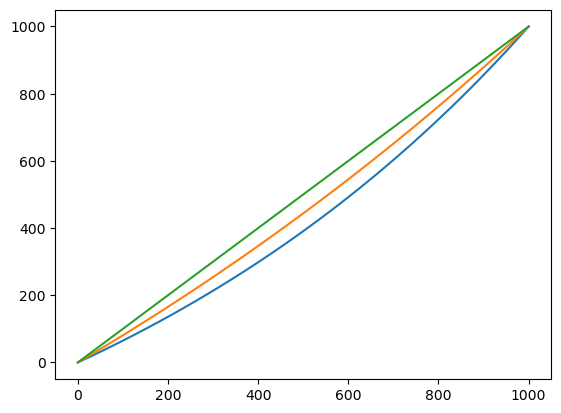

In [111]:
x = np.linspace(0,1000)
y1 = 1127 * np.log1p(x / 700)
y2 = 2212.4621972480586 * np.log1p(x / 1750)

plt.plot(y1,x)
plt.plot(y2,x)
plt.plot(x,x)

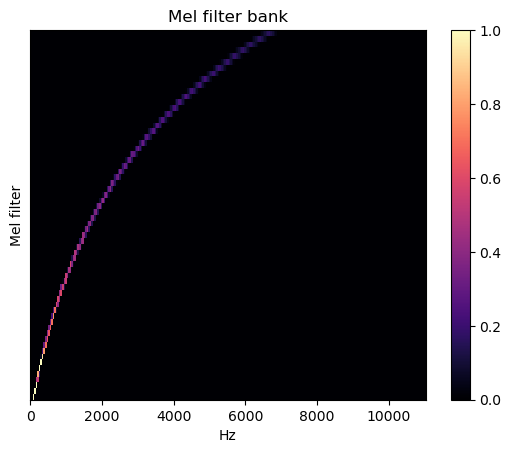

In [88]:
import matplotlib.pyplot as plt
melfb = create_mel_filterbank(sample_rate=48000, frame_len=512, num_bands=64, min_freq=150, max_freq=15000, corner=1750).T

fig, ax = plt.subplots()
img = librosa.display.specshow(melfb, x_axis='linear', ax=ax)
ax.set(ylabel='Mel filter', title='Mel filter bank')
fig.colorbar(img, ax=ax)

In [ ]:
melspec: np.ndarray = np.einsum("...ft,mf->...mt", S, mel_basis, optimize=True)

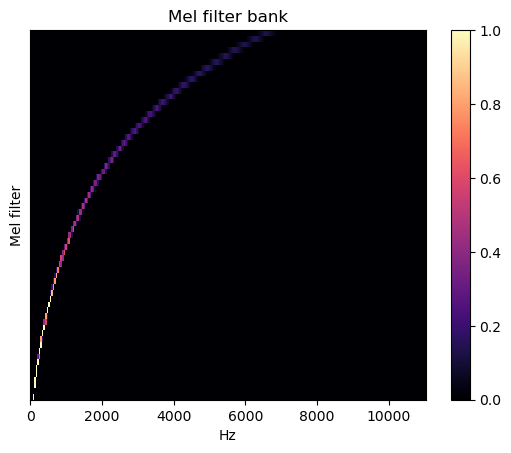

In [89]:
import matplotlib.pyplot as plt
melfb = create_mel_filterbank(sample_rate=48000, frame_len=512, num_bands=64, min_freq=150, max_freq=15000).T

fig, ax = plt.subplots()
img = librosa.display.specshow(melfb, x_axis='linear', ax=ax)
ax.set(ylabel='Mel filter', title='Mel filter bank')
fig.colorbar(img, ax=ax)

In [30]:
print(np.max(melfb_librosa), np.min(melfb_librosa), np.mean(melfb_librosa))
print(np.max(melfb), np.min(melfb), np.mean(melfb))

1.0 0.0 0.0038910506
1.0 0.0 0.0038302529182879376


In [26]:
np.sum(np.abs(melfb_librosa-melfb))

100.42011070096586

In [ ]:
melspec: np.ndarray = np.einsum("...ft,mf->...mt", S, mel_basis, optimize=True)